# 한국어 QA 모델 만들기
---

In [1]:
from tensorflow.keras.utils import get_file
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
import numpy as np
import tarfile
from nltk import FreqDist
from functools import reduce
import os
import re

from tqdm import tqdm

In [2]:
# initialization gpu ########################################################
import tensorflow as tf
def init_gpu():
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            # Currently, memory growth needs to be the same across GPUs
            for gpu in gpus:
                tf.config.experimental.set_memory_growth(gpu, True)
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs\n\n")
        except RuntimeError as e:
            # Memory growth must be set before GPUs have been initialized
            print(e, "\n\n")
        
init_gpu()

1 Physical GPUs, 1 Logical GPUs




## Step 1. 데이터 다운로드
---

- 압축풀기

In [3]:
# !unzip data/e-28-korean.zip -d data/e-28-korean

- 경로지정

In [4]:
home_dir = os.getenv('HOME')+'/workspace/aiffel-gd-nlp/GD14_babi_memory_net'
DATA_DIR = home_dir + '/data/e-28-korean'
TRAIN_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_train_kor.txt")
TEST_FILE = os.path.join(DATA_DIR, "qa1_single-supporting-fact_test_kor.txt")

- 데이터 확인

In [5]:
i = 0
lines = open(TRAIN_FILE , "rb")
for i, line in enumerate(lines):
    line = line.decode("utf-8").strip()
    print(line)
    if i == 20:
        break

1 필웅이는 화장실로 갔습니다.
2 은경이는 복도로 이동했습니다.
3 필웅이는 어디야? 	화장실	1
4 수종이는 복도로 복귀했습니다.
5 경임이는 정원으로 갔습니다.
6 수종이는 어디야? 	복도	4
7 은경이는 사무실로 갔습니다.
8 경임이는 화장실로 뛰어갔습니다.
9 수종이는 어디야? 	복도	4
10 필웅이는 복도로 갔습니다.
11 수종이는 사무실로 가버렸습니다.
12 수종이는 어디야? 	사무실	11
13 은경이는 정원으로 복귀했습니다.
14 은경이는 침실로 갔습니다.
15 경임이는 어디야? 	화장실	8
1 경임이는 사무실로 가버렸습니다.
2 경임이는 화장실로 이동했습니다.
3 경임이는 어디야? 	화장실	2
4 필웅이는 침실로 이동했습니다.
5 수종이는 복도로 갔습니다.
6 경임이는 어디야? 	화장실	2


## Step 2. 데이터 전처리
---

### 1. 데이터 불러오기

- 데이터를 읽어들여 스토리/질문/답변으로 분리한다.

In [6]:
def read_data(dir):
    stories, questions, answers = [], [], [] # 각각 스토리, 질문, 답변을 저장할 예정
    story_temp = [] # 현재 시점의 스토리 임시 저장
    lines = open(dir, "rb")

    for line in lines:
        line = line.decode("utf-8") # b' 제거
        line = line.strip() # '\n' 제거
        idx, text = line.split(" ", 1) # 맨 앞에 있는 id number 분리
        # 여기까지는 모든 줄에 적용되는 전처리

        if int(idx) == 1:
            story_temp = []
        
        if "\t" in text: # 현재 읽는 줄이 질문 (tab) 답변 (tab)인 경우
            question, answer, _ = text.split("\t") # 질문과 답변을 각각 저장
            stories.append([x for x in story_temp if x]) # 지금까지의 누적 스토리를 스토리에 저장
            questions.append(question)
            answers.append(answer)

        else: # 현재 읽는 줄이 스토리인 경우
            story_temp.append(text) # 임시 저장

    lines.close()
    return stories, questions, answers

In [7]:
train_data = read_data(TRAIN_FILE)
test_data = read_data(TEST_FILE)

In [8]:
train_stories, train_questions, train_answers = read_data(TRAIN_FILE)
test_stories, test_questions, test_answers = read_data(TEST_FILE)

In [9]:
print("train 스토리 개수:", len(train_stories))
print("train 질문 개수:", len(train_questions))
print("train 답변 개수:", len(train_answers))
print("test 스토리 개수:", len(test_stories))
print("test 질문 개수:", len(test_questions))
print("test 답변 개수:", len(test_answers))

train 스토리 개수: 10000
train 질문 개수: 10000
train 답변 개수: 10000
test 스토리 개수: 1000
test 질문 개수: 1000
test 답변 개수: 1000


- 데이터 확인

In [10]:
train_stories[4]

['필웅이는 화장실로 갔습니다.',
 '은경이는 복도로 이동했습니다.',
 '수종이는 복도로 복귀했습니다.',
 '경임이는 정원으로 갔습니다.',
 '은경이는 사무실로 갔습니다.',
 '경임이는 화장실로 뛰어갔습니다.',
 '필웅이는 복도로 갔습니다.',
 '수종이는 사무실로 가버렸습니다.',
 '은경이는 정원으로 복귀했습니다.',
 '은경이는 침실로 갔습니다.']

In [11]:
for i in range(5):
    print(f'Q : {train_questions[i]}')
    print(f'A : {train_answers[i]}\n')

Q : 필웅이는 어디야? 
A : 화장실

Q : 수종이는 어디야? 
A : 복도

Q : 수종이는 어디야? 
A : 복도

Q : 수종이는 어디야? 
A : 사무실

Q : 경임이는 어디야? 
A : 화장실



### 2. 토큰화

#### A. 단어 사전에 이름 추가

- 추가할 이름 추출

In [12]:
def extract_name(corpus):
    stop_word = ['은', '는', '이', '가']
    names = set()
    
    for sen in tqdm(corpus):
        idx = -1
        for w in stop_word:
            idx = sen.find(w)
            
            if idx > 0:
                names.add(sen[:idx])
                break
                
    return list(names)

In [13]:
names = extract_name(train_questions)

100%|██████████| 10000/10000 [00:00<00:00, 1475932.16it/s]


In [14]:
names

['수종이', '경임이', '은경이', '필웅이']

- tokenizer 정의 및 단어사전에 추출된 이름 추가

In [15]:
from ckonlpy.tag import Twitter
twitter = Twitter()

/home/aiffel-dj1/anaconda3/envs/aiffel/lib/python3.7/site-packages/konlpy/tag/_okt.py:16: UserWarning: "Twitter" has changed to "Okt" since KoNLPy v0.4.5.
  warn('"Twitter" has changed to "Okt" since KoNLPy v0.4.5.')


In [16]:
for name in names:
    twitter.add_dictionary(name, 'Noun')

- tokenizer 테스트

In [17]:
twitter_raw = Twitter()
test_sentences = [
    '은경이는 화장실로 이동했습니다.',
    '경임이는 정원으로 가버렸습니다.',
    '수종이는 복도로 뛰어갔습니다.',
    '필웅이는 부엌으로 복귀했습니다.',
    '수종이는 사무실로 갔습니다.',
    '은경이는 침실로 갔습니다.'
]

for sen in test_sentences:
    print("1️⃣", " ".join(twitter_raw.morphs(sen)))
    print("2️⃣", " ".join(twitter.morphs(sen)))
    print()

1️⃣ 은 경이 는 화장실 로 이동 했습니다 .
2️⃣ 은경이 는 화장실 로 이동 했습니다 .

1️⃣ 경 임 이 는 정원 으로 가버렸습니다 .
2️⃣ 경임이 는 정원 으로 가버렸습니다 .

1️⃣ 수종 이 는 복도 로 뛰어갔습니다 .
2️⃣ 수종이 는 복도 로 뛰어갔습니다 .

1️⃣ 필웅이 는 부엌 으로 복귀 했습니다 .
2️⃣ 필웅이 는 부엌 으로 복귀 했습니다 .

1️⃣ 수종 이 는 사무실 로 갔습니다 .
2️⃣ 수종이 는 사무실 로 갔습니다 .

1️⃣ 은 경이 는 침실 로 갔습니다 .
2️⃣ 은경이 는 침실 로 갔습니다 .



#### B. 토큰화

- 토큰화 함수

In [18]:
def tokenize(sentence, tokenizer):
    morphsem = tokenizer.morphs(sentence)
    stop_words = ['은', '는', '이', '가', '으로', '로']
    return [ word for word in morphsem if word not in stop_words ]

- 단어 사전 정의 함수

In [19]:
def preprocess_data(train_data, test_data, tokenizer):
    counter = FreqDist()
    
    # 두 문장의 story를 하나의 문장으로 통합하는 함수
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    # 각 샘플의 길이를 저장하는 리스트
    story_len = []
    question_len = []
    
    for stories, questions, answers in [train_data, test_data]:
        for story in tqdm(stories, desc=f'story'):
            stories = tokenize(flatten(story), tokenizer) # 스토리의 문장들을 펼친 후 토큰화
            story_len.append(len(stories)) # 각 story의 길이 저장
            for word in stories: # 단어 집합에 단어 추가
                counter[word] += 1
        for question in tqdm(questions, desc=f'questions:8f'):
            question = tokenize(question, tokenizer)
            question_len.append(len(question))
            for word in question:
                counter[word] += 1
        for answer in tqdm(answers, 'answers'):
            answer = tokenize(answer, tokenizer)
            for word in answer:
                counter[word] += 1

    # 단어장 생성
    word2idx = {word : (idx + 1) for idx, (word, _) in enumerate(counter.most_common())}
    idx2word = {idx : word for word, idx in word2idx.items()}

    # 가장 긴 샘플의 길이
    story_max_len = np.max(story_len)
    question_max_len = np.max(question_len)

    return word2idx, idx2word, story_max_len, question_max_len

In [20]:
word2idx, idx2word, story_max_len, question_max_len = preprocess_data(train_data, 
                                                                      test_data,
                                                                      twitter)

answers: 100%|██████████| 1000/1000 [00:00<00:00, 31799.84it/s]


In [21]:
vocab_size = len(word2idx) + 1

- 정수 인코딩 및 패딩 추가 함수

In [22]:
def vectorize(data, word2idx, tokenizer, story_maxlen, question_maxlen):
    Xs, Xq, Y = [], [], []
    flatten = lambda data: reduce(lambda x, y: x + y, data)

    stories, questions, answers = data
    for story, question, answer in tqdm(zip(stories, questions, answers),
                                        total=len(stories)):
        xs = [word2idx[w] for w in tokenize(flatten(story), tokenizer)]
        xq = [word2idx[w] for w in tokenize(question, tokenizer)]
        Xs.append(xs)
        Xq.append(xq)
        Y.append(word2idx[answer])

    # 스토리와 질문은 각각의 최대 길이로 패딩
    # 정답은 원-핫 인코딩
    return pad_sequences(Xs, maxlen=story_maxlen),\
           pad_sequences(Xq, maxlen=question_maxlen),\
           to_categorical(Y, num_classes=len(word2idx) + 1)

In [23]:
Xstrain, Xqtrain, Ytrain = vectorize(train_data, 
                                     word2idx, 
                                     twitter,
                                     story_max_len, 
                                     question_max_len)
Xstest, Xqtest, Ytest = vectorize(test_data, 
                                  word2idx, 
                                  twitter,
                                  story_max_len, 
                                  question_max_len)

100%|██████████| 1000/1000 [00:03<00:00, 250.63it/s]


In [24]:
print(Xstrain.shape, Xqtrain.shape, Ytrain.shape, Xstest.shape, Xqtest.shape, Ytest.shape)

(10000, 50) (10000, 4) (10000, 21) (1000, 50) (1000, 4) (1000, 21)


## Step 3. 메모리 네트워크 구현
---

- package import

In [25]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Embedding, Layer
from tensorflow.keras.layers import Permute, dot, add, concatenate
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input, Activation
import matplotlib.pyplot as plt

![img](https://i.ibb.co/n0FWcfv/03.png)

### 1. Encoder

- EmbeddingA, EmbeddingB, EmbeddingC

In [26]:
class Encoder(Layer):
    def __init__(self, vocab_size, embed_size=100, input_length=None, dropout_rate=0.1):
        super(Encoder, self).__init__()
        if input_length:
            self.embedding = Embedding(input_dim=vocab_size,
                                       output_dim=embed_size,
                                       input_length=input_length)
        else:
            self.embedding = Embedding(input_dim=vocab_size,
                                       output_dim=embed_size)
        self.drop_out = Dropout(dropout_rate)
    
    def call(self, x):
        x = self.embedding(x)
        x = self.drop_out(x)
        
        return x

### 2. MatchingSimilarity

In [27]:
class MatchingSimilarity(Layer):
    def __init__(self):
        super(MatchingSimilarity, self).__init__()
        self.activation = Activation('softmax')
    
    def call(self, x, y):
        x = dot([x, y], axes=-1, normalize=False)
        x = self.activation(x)
        
        return x

### 3. Predict

In [28]:
class Response(Layer):
    def __init__(self):
        super(Response, self).__init__()
    
    def call(self, x, y):
        x = add([x, y])
        x = Permute((2, 1))(x)
        return x

### 4. 조립

In [29]:
class MemoryNetwork(Model):
    def __init__(self,
                 vocab_size, 
                 embed_size=100, 
                 question_max_len=20,
                 lstm_size=64, 
                 dropout_rate=0.3):
        super(MemoryNetwork, self).__init__(self)
        self.input_encoder_m = Encoder(vocab_size,
                                       embed_size=embed_size,
                                       dropout_rate=dropout_rate)
        self.input_encoder_c = Encoder(vocab_size, 
                                       embed_size=question_max_len, 
                                       dropout_rate=dropout_rate)
        self.question_encoder = Encoder(vocab_size, 
                                        embed_size=embed_size,
                                       input_length=question_max_len,
                                       dropout_rate=dropout_rate)
        self.matching_similarity = MatchingSimilarity()
        self.response = Response()
        self.lstm = LSTM(lstm_size)
        self.drop_out = Dropout(dropout_rate)
        self.dense = Dense(vocab_size)
        self.softmax = Activation('softmax')
        
    def call(self, x):
        input_sequence = x[0]
        question = x[1]
        input_encoded_m = self.input_encoder_m(input_sequence)
        input_encoded_c = self.input_encoder_c(input_sequence)
        question_encoded = self.question_encoder(question)
        
        match = self.matching_similarity(input_encoded_m, question_encoded)
        response = self.response(match, input_encoded_c)
        answer = concatenate([response, question_encoded])
        
        answer = self.lstm(answer)
        answer = self.drop_out(answer)
        answer = self.dense(answer)
        answer = self.softmax(answer)
        
        return answer

## Step 4. 모델 정의 및 학습
---

### 1. 모델 정의

In [38]:
hp = {
    'train_epochs' : 120,
    'batch_size' : 32,
    'embed_size' : 50,
    'lstm_size' : 64,
    'dropout_rate' : 0.30
}

In [39]:
mmn = MemoryNetwork(vocab_size,
                    embed_size=hp['embed_size'],
                    question_max_len=question_max_len,
                    lstm_size=hp['lstm_size'],
                    dropout_rate=hp['dropout_rate'])
mmn.compile(optimizer='rmsprop', loss='categorical_crossentropy',
              metrics=['acc'])

- Input 정의

In [40]:
input_sequence = Input((story_max_len,))
question = Input((question_max_len,))
 
print('Stories :', input_sequence)
print('Question:', question)

Stories : KerasTensor(type_spec=TensorSpec(shape=(None, 50), dtype=tf.float32, name='input_3'), name='input_3', description="created by layer 'input_3'")
Question: KerasTensor(type_spec=TensorSpec(shape=(None, 4), dtype=tf.float32, name='input_4'), name='input_4', description="created by layer 'input_4'")


### 2. 학습

In [41]:
history = mmn.fit([Xstrain, Xqtrain],
                 Ytrain, hp['batch_size'], hp['train_epochs'],
                 validation_data=([Xstest, Xqtest], Ytest))

Epoch 1/120
313/313 [==============================] - 3s 4ms/step - loss: 2.0393 - acc: 0.1651 - val_loss: 1.7994 - val_acc: 0.1760
Epoch 2/120
313/313 [==============================] - 1s 3ms/step - loss: 1.7957 - acc: 0.1882 - val_loss: 1.6157 - val_acc: 0.3950
Epoch 3/120
313/313 [==============================] - 1s 4ms/step - loss: 1.6229 - acc: 0.3358 - val_loss: 1.4862 - val_acc: 0.4350
Epoch 4/120
313/313 [==============================] - 1s 4ms/step - loss: 1.5245 - acc: 0.3890 - val_loss: 1.4612 - val_acc: 0.4250
Epoch 5/120
313/313 [==============================] - 1s 3ms/step - loss: 1.5007 - acc: 0.4029 - val_loss: 1.4153 - val_acc: 0.4620
Epoch 6/120
313/313 [==============================] - 1s 4ms/step - loss: 1.4251 - acc: 0.4534 - val_loss: 1.3616 - val_acc: 0.4650
Epoch 7/120
313/313 [==============================] - 1s 3ms/step - loss: 1.4035 - acc: 0.4547 - val_loss: 1.3313 - val_acc: 0.4920
Epoch 8/120
313/313 [==============================] - 1s 3ms/step - 

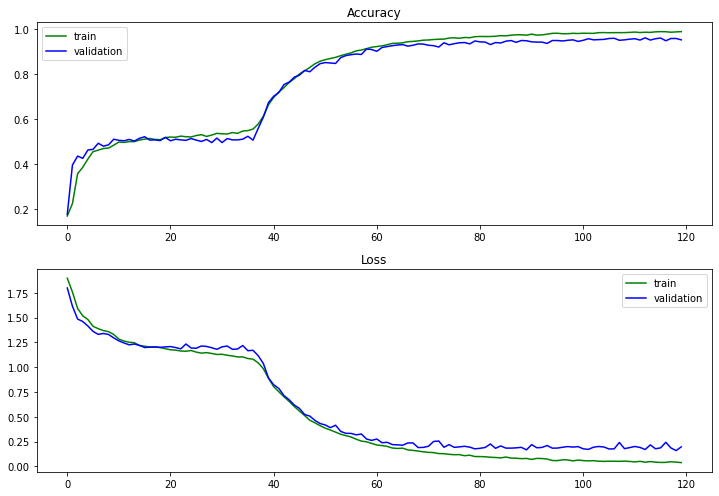

In [42]:
# plot accuracy and loss plot
plt.figure(figsize=(10, 7))

plt.subplot(211)
plt.title("Accuracy")
plt.plot(history.history["acc"], color="g", label="train")
plt.plot(history.history["val_acc"], color="b", label="validation")
plt.legend(loc="best")

plt.subplot(212)
plt.title("Loss")
plt.plot(history.history["loss"], color="g", label="train")
plt.plot(history.history["val_loss"], color="b", label="validation")
plt.legend(loc="best")

plt.tight_layout()
plt.show()

### 3. 예측 결과

In [43]:
# labels
ytest = np.argmax(Ytest, axis=1)

# get predictions
Ytest_ = mmn.predict([Xstest, Xqtest])
ytest_ = np.argmax(Ytest_, axis=1)

In [44]:
NUM_DISPLAY = 30

print("{:20}|{:7}|{}".format("질문", "실제값", "예측값"))
print(39 * "-")

for i in range(NUM_DISPLAY):
    question = " ".join([idx2word[x] for x in Xqtest[i].tolist()])
    label = idx2word[ytest[i]]
    prediction = idx2word[ytest_[i]]
    print("{:20}: {:8} {}".format(question, label, prediction))

질문                  |실제값    |예측값
---------------------------------------
은경이 어디 야 ?          : 복도       복도
필웅이 어디 야 ?          : 화장실      화장실
경임이 어디 야 ?          : 부엌       부엌
경임이 어디 야 ?          : 복도       복도
경임이 어디 야 ?          : 부엌       부엌
경임이 어디 야 ?          : 복도       복도
경임이 어디 야 ?          : 정원       정원
수종이 어디 야 ?          : 복도       복도
경임이 어디 야 ?          : 사무실      사무실
수종이 어디 야 ?          : 사무실      사무실
필웅이 어디 야 ?          : 부엌       부엌
필웅이 어디 야 ?          : 정원       정원
수종이 어디 야 ?          : 사무실      사무실
필웅이 어디 야 ?          : 침실       침실
필웅이 어디 야 ?          : 침실       침실
은경이 어디 야 ?          : 부엌       부엌
은경이 어디 야 ?          : 정원       정원
은경이 어디 야 ?          : 부엌       부엌
수종이 어디 야 ?          : 사무실      사무실
은경이 어디 야 ?          : 부엌       부엌
필웅이 어디 야 ?          : 복도       복도
은경이 어디 야 ?          : 사무실      사무실
은경이 어디 야 ?          : 사무실      사무실
경임이 어디 야 ?          : 복도       복도
수종이 어디 야 ?          : 침실       정원
경임이 어디 야 ?          : 침실       침실
필웅이 어디 야 ?          : 침실       침실
수종

30개의 예측 결과를 출력해 보았고 그 중 29개가 옳바를 결과를 예측한 것을 확인할 수 있었다.

### 4. 모델 평가

In [45]:
mmn.evaluate([Xstest, Xqtest], Ytest)

32/32 [==============================] - 0s 2ms/step - loss: 0.1974 - acc: 0.9520


[0.19735872745513916, 0.9520000219345093]

evalutaion 결과, 95% 이상의 정확도를 보였다.

## Step 5. 결론
---

### 프로젝트 평가

1. 한국어의 특성에 알맞게 전처리가 진행되었다.<br>한국어 특성에 따른 토큰화, 임베딩을 거쳐 데이터셋이 적절히 구성되었다.
    - 형태소 분석기를 사용하여 토큰화를 진행하였다.
2. 메모리 네트워크가 정상적으로 구현되어 학습이 안정적으로 진행되었다. validation loss가 안정적으로 수렴하는 것을 확인하고 이를 시각화하였다. 
    - 모델이 정작적으로 작동하였고, validation loss가 안정적으로 감소하였다.
3. 메모리 네트워크를 통해 한국어 bAbI 태스크의 높은 정확도를 달성하였다. <br>추론 태스크의 테스트 정확도가 90% 이상 달성하였다.
    - 모델의 test accuracy는 95.2%로 90% 이상을 달성하였다.

## Ref
---

- [2) MemN으로 한국어 QA 해보기](https://wikidocs.net/85470)